# EO-HARVEST
## demonstration with WekEO Service (Eumetsat/ECMWF/CMEMS)

In [1]:
# import eo-harvest package
import eo_harvest

# and other stuff
import datetime
import shapely.geometry


## Simple search
Searching granules for a dataset using time and space criteria. Let's search for instance Sentinel-2 MSI dataset, whose id is `EO:EUM:DAT:SENTINEL-3:SR_2_WAT___` (refer to https://moi.wekeo.eu/data for dataset identifiers).

**Warning: there is a bug in Wekeo API: the following query will return granules from other datasets as well. This has been reported and should be fixed soon.**

In [6]:
# define search area as shapely geometry (here a simple rectangular box)
area = shapely.geometry.box(-50, -20, -20, 20)

# define search time frame
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 1, 2)

# performs the search
# first args is the data store, here `Wekeo`
res = eo_harvest.search_granule(
    'Wekeo',
    'EO:EUM:DAT:SENTINEL-3:SR_2_WAT___',
    start,
    end,
    area,
)


## Inspecting the result

We get in ``res`` variable the list of granules, with their properties, that were returned by the query. A few operations can be done on these results.

### Display result footprints

It is possible to display the location of these found granules using ``plot`` function:

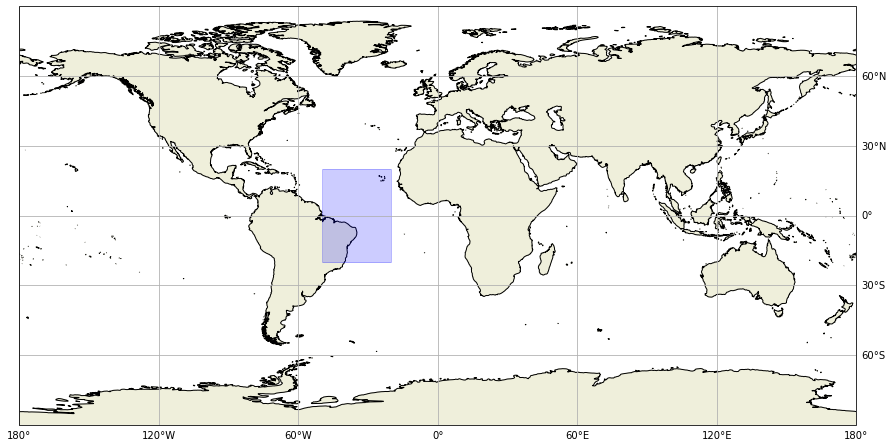

In [3]:
# display the location of found granules
eo_harvest.plot(res, clip=area)

### Description of the returned granules

The properties of the returned granules can be inspected, just printing the returned granule objects:

In [4]:
# display the details of the first granule in the returned list
print(res.items[0])

S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003
   start: 2020-01-01 23:37:21.988000
   end: 2020-01-02 01:18:21.140000
   url: 9dce48ec-90cd-4abb-83ff-092636ba8ff1/S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003




In [5]:
# print the name and URL of all found granules
for c in res.items:
    print(c.name, c.url)


S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003 9dce48ec-90cd-4abb-83ff-092636ba8ff1/S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003
S3B_SR_1_SRA____20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004 59fa4695-e561-48dc-b997-00921a066cb2/S3B_SR_1_SRA____20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004
S3B_SR_1_SRA_BS_20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004 08acc5a9-e5b6-4cfd-be62-f7e8dfbc0ef0/S3B_SR_1_SRA_BS_20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004
S3B_SR_1_SRA_A__20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004 349bf629-69a1-49be-8981-15c5ccf3e9c6/S3B_SR_1_SRA_A__20200101T233722_20200102T002752_20200127T151023_3029_034_044______MAR_O_NT_004
S3B_SR_2_WAT____20200101T234230_20200102T002751_20200127T163142_2721_034_044______MAR_O_NT_0

## Quicklook

Quicklooks are currently not available on Wekeo store.

## Download

Each returned granule (in ``res.items`` list) can be downloaded (``wget`` is used behind the scene), calling the ``download`` method on the granule to download. Main argument, ``mystore`` is the root folder where to save the downloaded granule: it will be saved in a subfolder ``<store>/<product identifier>/<year>/<day>/``. 

In [6]:
res.items[0].download(mystore='.', silent=False)

Downloading: https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/gQDgcbEMkDihcfV71WOwBpP4GKU to Wekeo/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___/2020/001/S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003
['wget', '-c', '--auth-no-challenge', '-P', 'Wekeo/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___/2020/001', '--output-document', 'S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003', '--header', '"authorization: 349d61da-b46b-3745-bf5f-30418d932a74"', '--user', '*****', '--password', '****', 'https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/gQDgcbEMkDihcfV71WOwBpP4GKU']
Failed (status=8) execution of: wget -c --auth-no-challenge -P Wekeo/EO:EUM:DAT:SENTINEL-3:SR_2_WAT___/2020/001 --output-document S3B_SL_2_WST____20200101T233722_20200102T011821_20200106T202647_6059_034_044______MAR_O_NT_003 --header "authorization: 349d61da-b46b-3745-bf5f-30418d932a74" --user **** 

False

## Advanced usage : multi-search
Let's search crossovers over a storm track for instance, e.g. a series of time and locations. The `multisearch` function allows to pass on the full list of time and locations, and harvest a consolidate result.

This step may takes a long time here, as we send a search request for each storm track time step (every hour), so more than 200 requests for the whole storm life time.

In [ ]:
# first get a storm track from our storm track directory
import certoolbox.hurricanes

# identifier of the storm in ATCF convention
ATCF_NAME = 'wp202019'

# read the track
track = certoolbox.hurricanes.track(ATCF_NAME)

# transform into a list of time and search areas, using a colocation radius of 0.5 degrees (to ensure we are close to storm eye).
# The track is interpolated hourly for better precision and we will search within 30 minutes around each hourly track point.
targets = certoolbox.hurricanes.searchable_track(track, radius=0.5, interpolate='1H')

Run the multi-search (may take some time) and display result

In [ ]:
res = eo_harvest.multisearch(
    'Wekeo',
    'EO:EUM:DAT:SENTINEL-3:SR_2_WAT___',
    targets,
    delta_time=datetime.timedelta(minutes=30),
)

In [ ]:
eo_harvest.plot(res)